In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from horizonplot import horizonplot
%config InlineBackend.figure_format = 'retina'

In [2]:
def length_to_windows(length_df, pops, window_size=100000):
    #pops = sorted(length_df["reference"].unique())
    window_l = list(range(length_df.pos.values[0], length_df.end_pos.values[-1], window_size))
    overall_dict = {"windows": window_l}
    for p in pops:
        overall_dict[p] = np.zeros(len(window_l))
    for i in range(len(window_l)):
        w = window_l[i]
        # Finding all paintings that start in this window.
        s_df = length_df.loc[(length_df.pos >= w) & (length_df.pos < w+window_size)]
        for index, row in s_df.iterrows():
            # x decides how many windows it should go beyond the current.
            # if x==0, it both starts and ends in the same window
            x = (row.pos-w+row.length)//window_size
            if x == 0:
                overall_dict[row["reference"]][i] += int(row.length)
            # Otherwise, the current window is filled from row.pos to window end
            else:
                overall_dict[row["reference"]][i] += int((w+window_size)-row.pos)
                # Then iterated for each full window (which is all windows < x)
                for s in range(x-1):
                    overall_dict[row["reference"]][i+1+s] += int(window_size)
                # Then finally added the ending window
                # print(row.paint_length+row.pos, (w+x*window_size), x, w)
                overall_dict[row["reference"]][i+x] += int(row.length+row.pos-(w+x*window_size))
    df = pd.DataFrame(overall_dict)
    return df

def create_paint_df_ind(df, ind, mapping, ns_map):
    d = {}
    d["pos"] = df.spos
    d["end_pos"] = df.epos -1
    d["length"] = df.epos - df.spos
    d["reference"] = df[ind].map(mapping)
    d["n/s"] = d["reference"].map(ns_map)
    d["individual"] = ind[:-2]
    d["haplotype"] = ind[-1:]
    return pd.DataFrame(d)

In [3]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering_sci.txt", sep =" ")

In [4]:
! tree ../steps

../steps
└── rfmix_gen100
    ├── aut_genetic_map.txt
    ├── eth_olive_focus
    │   ├── all_chrchrX.fb.tsv
    │   ├── all_chrchrX.msp.tsv
    │   ├── all_chrchrX.rfmix.Q
    │   ├── all_chrchrX.sis.tsv
    │   ├── all_chrX.fb.tsv
    │   ├── all_chrX.msp.tsv
    │   ├── all_chrX.rfmix.Q
    │   ├── all_chrX.sis.tsv
    │   ├── aut_query.bcf
    │   ├── aut_query.bcf.csi
    │   ├── aut_ref.bcf
    │   ├── aut_ref.bcf.csi
    │   ├── chr9.fb.tsv
    │   ├── chr9.msp.tsv
    │   ├── chr9.rfmix.Q
    │   ├── chr9.sis.tsv
    │   ├── female_chrchrX.fb.tsv
    │   ├── female_chrchrX.msp.tsv
    │   ├── female_chrchrX.rfmix.Q
    │   ├── female_chrchrX.sis.tsv
    │   ├── female_chrX.fb.tsv
    │   ├── female_chrX.msp.tsv
    │   ├── female_chrX.rfmix.Q
    │   ├── female_chrX.sis.tsv
    │   ├── ref_names.txt
    │   ├── X_all_query.bcf
    │   ├── X_all_query.bcf.csi
    │   ├── X_all_ref.bcf
    │   ├── X_all_ref.bcf.csi
    │   ├── X_female_query.bcf
    │   ├── X_female_query.bcf.csi

In [5]:
rfmix_path = "../steps/rfmix_gen100/eth_olive_focus/"

In [6]:
mapping_df = pd.read_csv(rfmix_path + "ref_names.txt", sep = "\t", names=["ID", "Origin"])

In [7]:
north_south_mapping = {}
o_order = sorted((mapping_df.Origin.unique()))
for o in range(len((mapping_df.Origin.unique()))):
    north_south_mapping[o_order[o]] = o

In [8]:
north_south_mapping

{'Anubis, Tanzania': 0,
 'Cynocephalus, Central Tanzania': 1,
 'Hamadryas, Ethiopia': 2,
 'Papio, Senegal': 3}

In [9]:
df_l = []
# for chrom in ["all_chrX", "female_chrX"]:
for chrom in ["all_chrX"]: 
    input_file = rfmix_path + "{}.msp.tsv".format(chrom)
    chr_df = pd.read_csv(input_file, sep = "\t", header=1)
    file = open(input_file, 'r')
    line1 = file.readline()
    file.close()
    number_subpop_mapping = {}
    for subpop in line1.strip().split("\t"):
        # Splitting to create lists containing two values - subpop and number.
        subpop_number = subpop.split(": ")[-1].split("=")
        number_subpop_mapping[int(subpop_number[1])] = subpop_number[0]
    for hap in chr_df.columns[6:]:
        paint_df = create_paint_df_ind(chr_df, hap, number_subpop_mapping, north_south_mapping)
        paint_df["chrom"] = "{}".format(chrom)
        df_l.append(paint_df)
length_df = pd.concat(df_l)

In [10]:
window_df_l = []
for chrom in length_df.chrom.unique():
    print(chrom)
    chrom_df = length_df.loc[length_df.chrom == "{}".format(chrom)]
    pops = chrom_df.reference.unique()
    for ind in chrom_df.individual.unique():
        ind_df = chrom_df.loc[chrom_df.individual == ind]
        window_df_ind = length_to_windows(ind_df, pops)
        window_df_ind["chrom"] = "{}".format(chrom)
        window_df_ind["individual"] = ind
        window_df_l.append(window_df_ind)
window_df = pd.concat(window_df_l)

all_chrX


In [11]:
window_df["Origin"] = window_df.individual.map(dict(zip(meta_data_samples.PGDP_ID,
                                                        meta_data_samples.Origin)))
window_df["north"] = window_df["Hamadryas, Ethiopia"]+window_df["Papio, Senegal"]
window_df["norm_north"] = (window_df.north-window_df.iloc[:,1:5].sum(axis=1)/2)
window_df["start"] = window_df["windows"]

In [12]:
#window_df.to_csv("../steps/rfmix_v3_chrX_windowed_df.txt", index=False)

In [13]:
female_olives = meta_data_samples.loc[(meta_data_samples.Species== "anubis") & (meta_data_samples.Sex== "F")].PGDP_ID
female_yellows = meta_data_samples.loc[(meta_data_samples.Species== "cynocephalus") & (meta_data_samples.Sex== "F")].PGDP_ID

/home/kmt/miniconda3/envs/baboons/lib/python3.8/site-packages/horizonplot/__init__.py:77: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cut is 'fixed':
/home/kmt/miniconda3/envs/baboons/lib/python3.8/site-packages/horizonplot/__init__.py:77: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cut is 'fixed':


KeyboardInterrupt: 

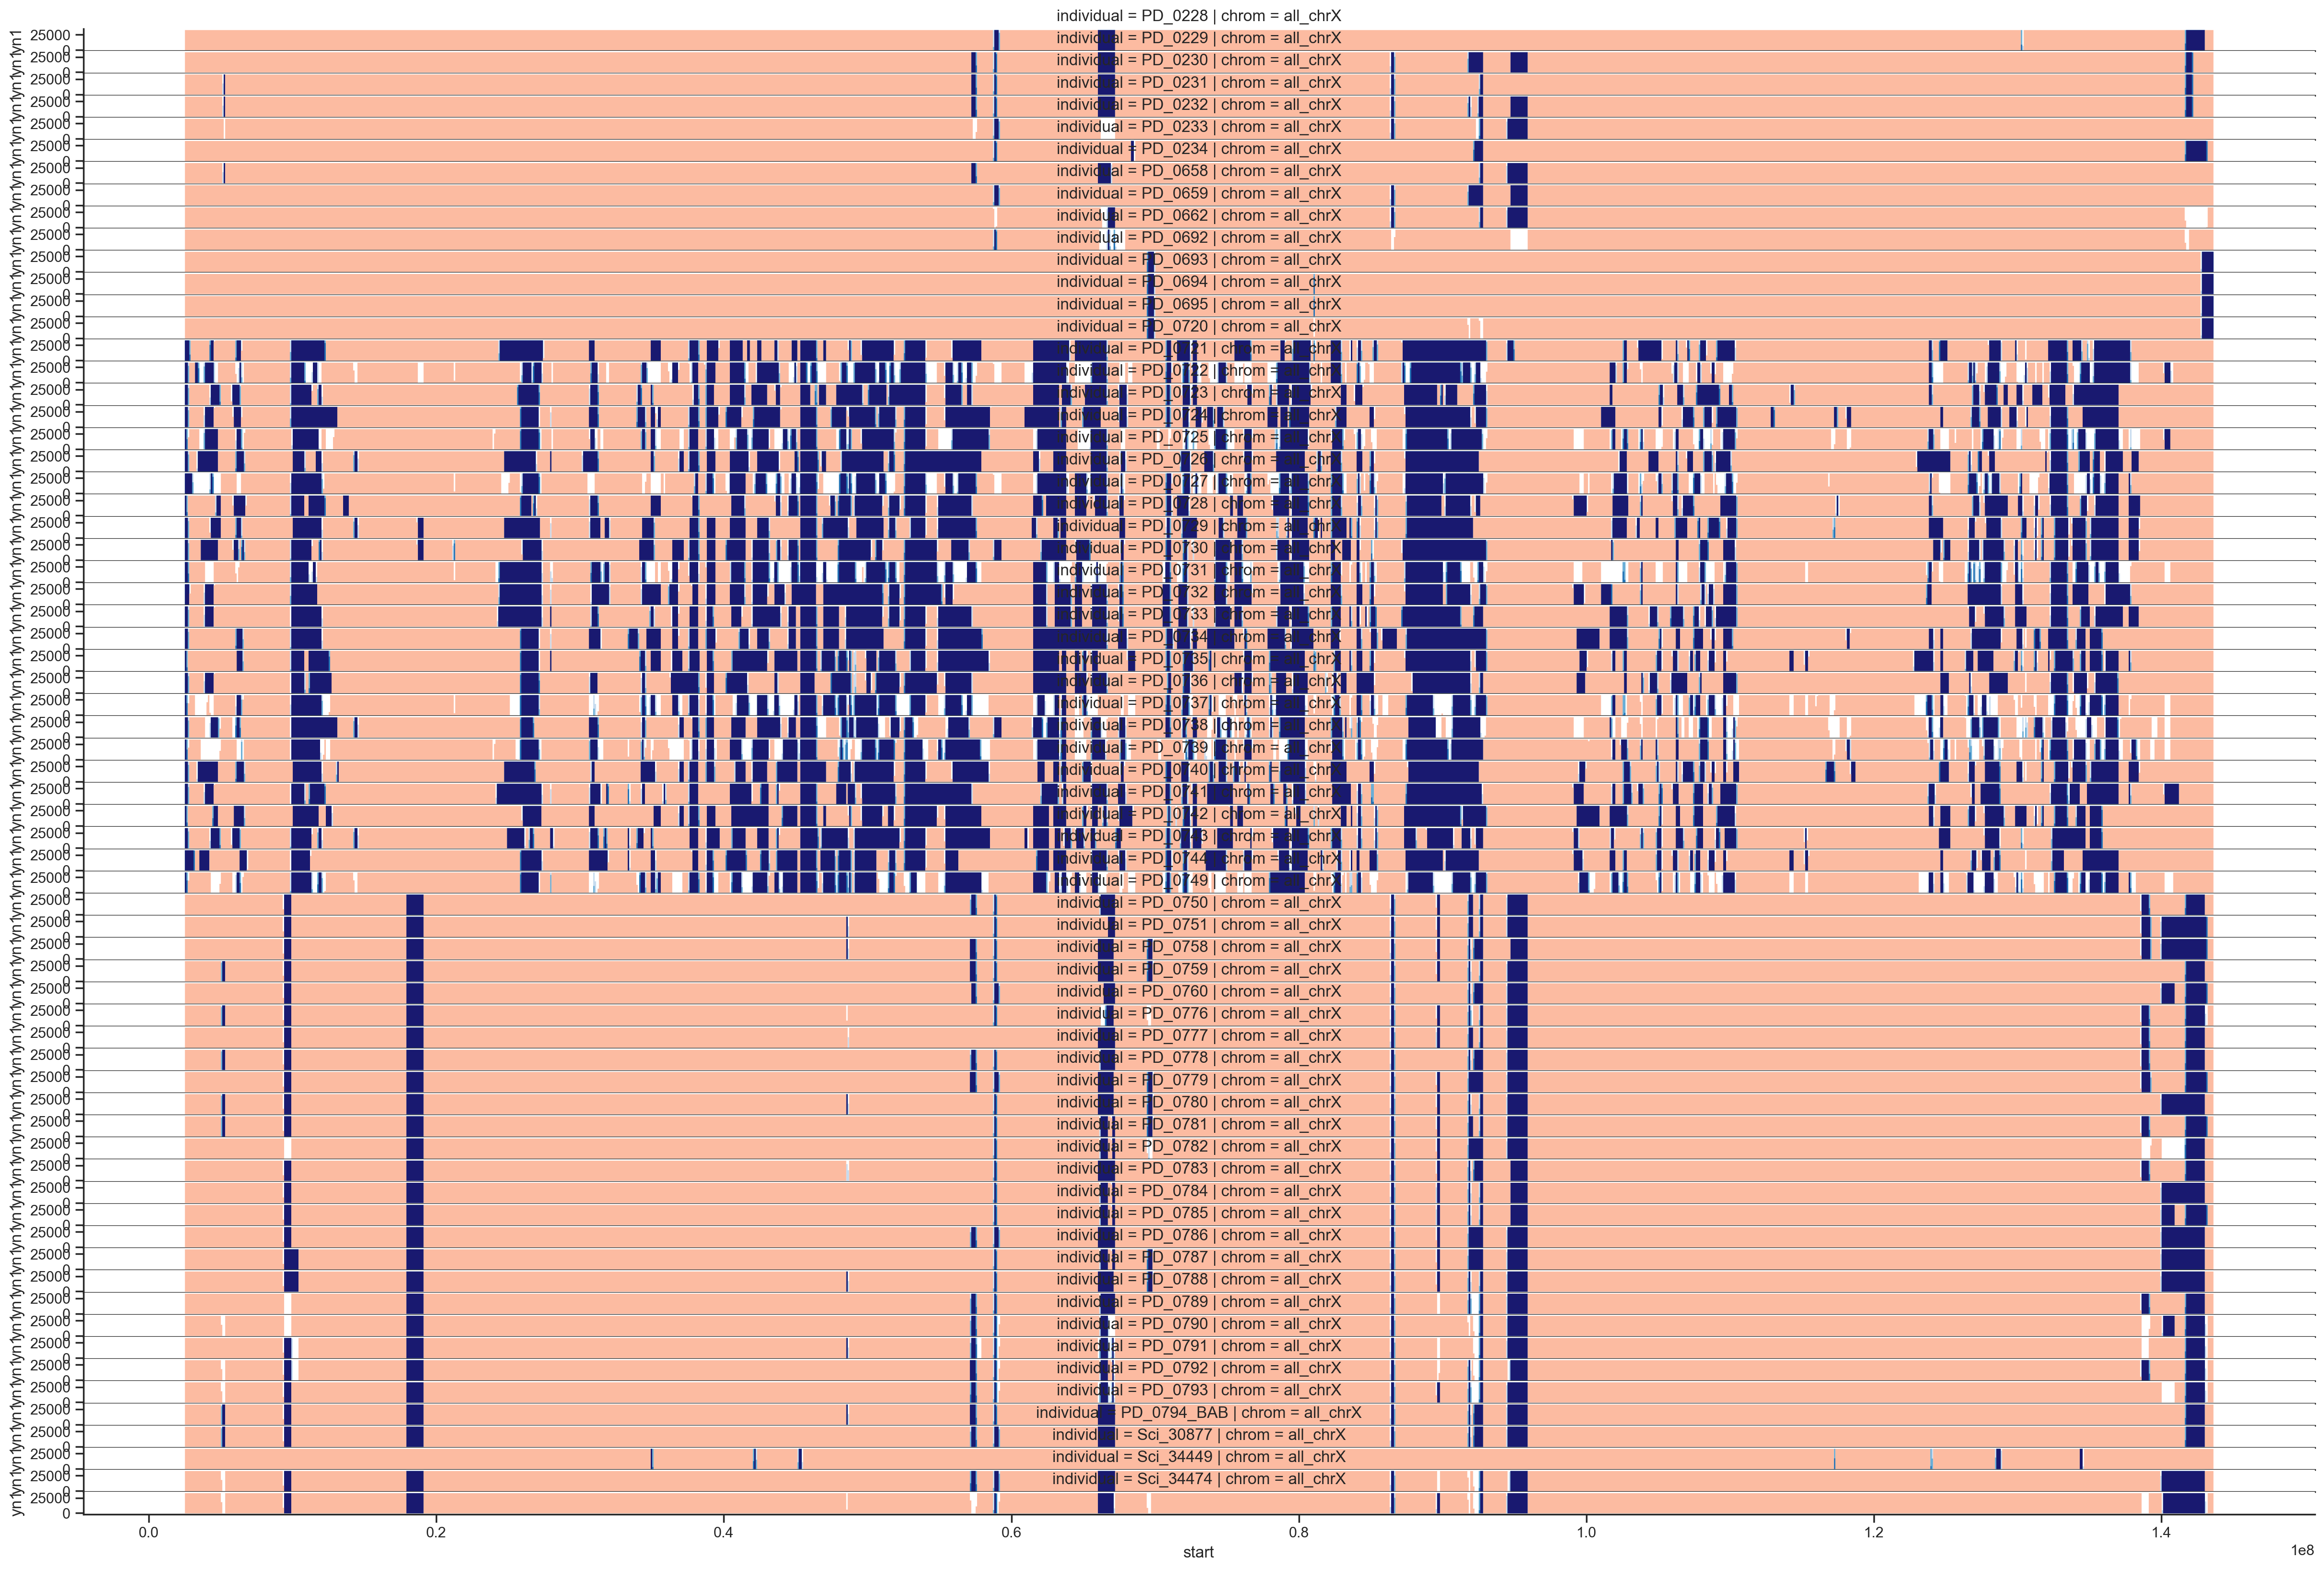

In [17]:
#female_chrX = window_df.loc[window_df.chrom == "female_chrX"]
fig = horizonplot(window_df, 'norm_north', width=2, col='chrom', row='individual', size=0.3, aspect=100, cut=33000)

['sample0', 'sample1', 'sample2', 'sample3', 'sample4'] ...
[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 0 1 ... 1 0 1]]


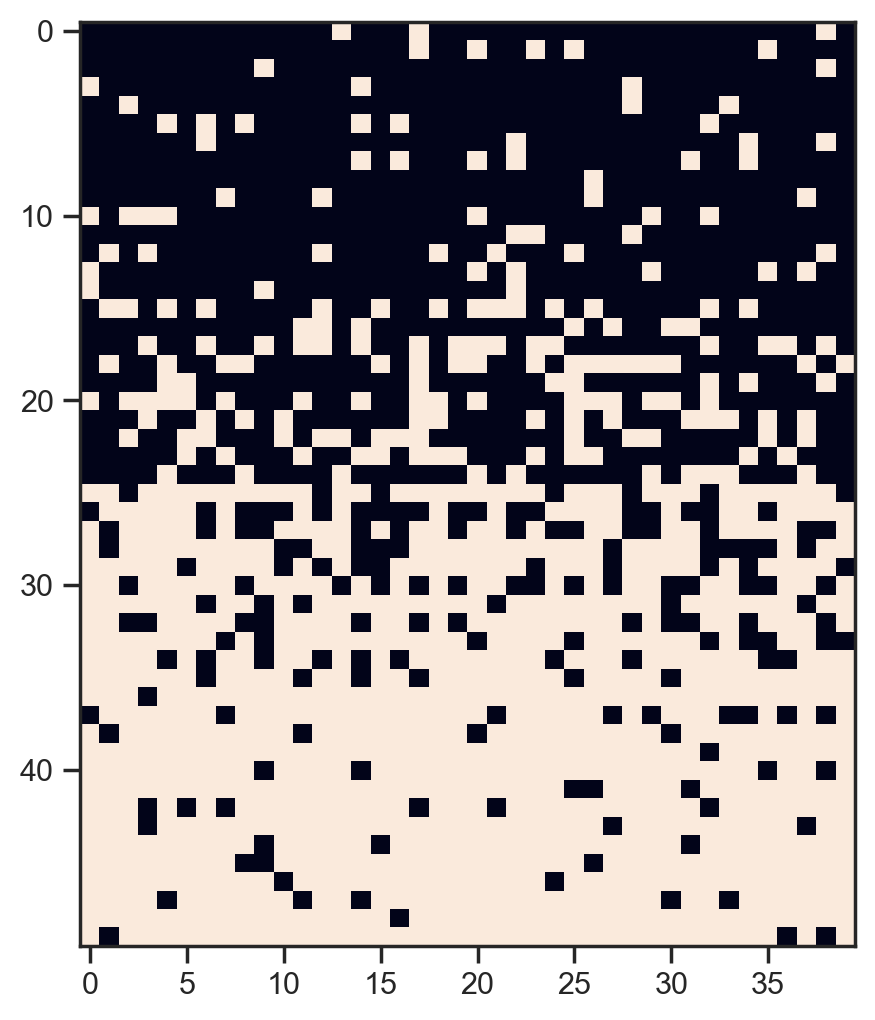

In [18]:
sample_name_list = [f'sample{i}' for i in range(50)]
seq_window_list = np.concatenate([np.random.choice([0, 1], size=600, p=[0.9, 0.1]).reshape(15, -1), 
                                  np.random.choice([0, 1], size=400, p=[0.7, 0.3]).reshape(10, -1),                                  
                                  np.random.choice([0, 1], size=400, p=[0.3, 0.7]).reshape(10, -1),
                                  np.random.choice([0, 1], size=600, p=[0.1, 0.9]).reshape(15, -1)])
print(sample_name_list[:5], '...')
print(seq_window_list)
plt.figure(figsize=(5, 6))
plt.imshow(seq_window_list, aspect='auto') ;

Index of sorted haplotypes: [8, 9, 2, 0, 6, 14, 3, 4, 11, 1, 13, 7, 5, 12, 16, 19, 10, 24, 15, 22, 21, 17, 23, 20, 18, 26, 27, 30, 32, 28, 34, 37, 29, 25, 33, 42, 31, 35, 47, 38, 40, 49, 41, 44, 45, 43, 46, 36, 39, 48]


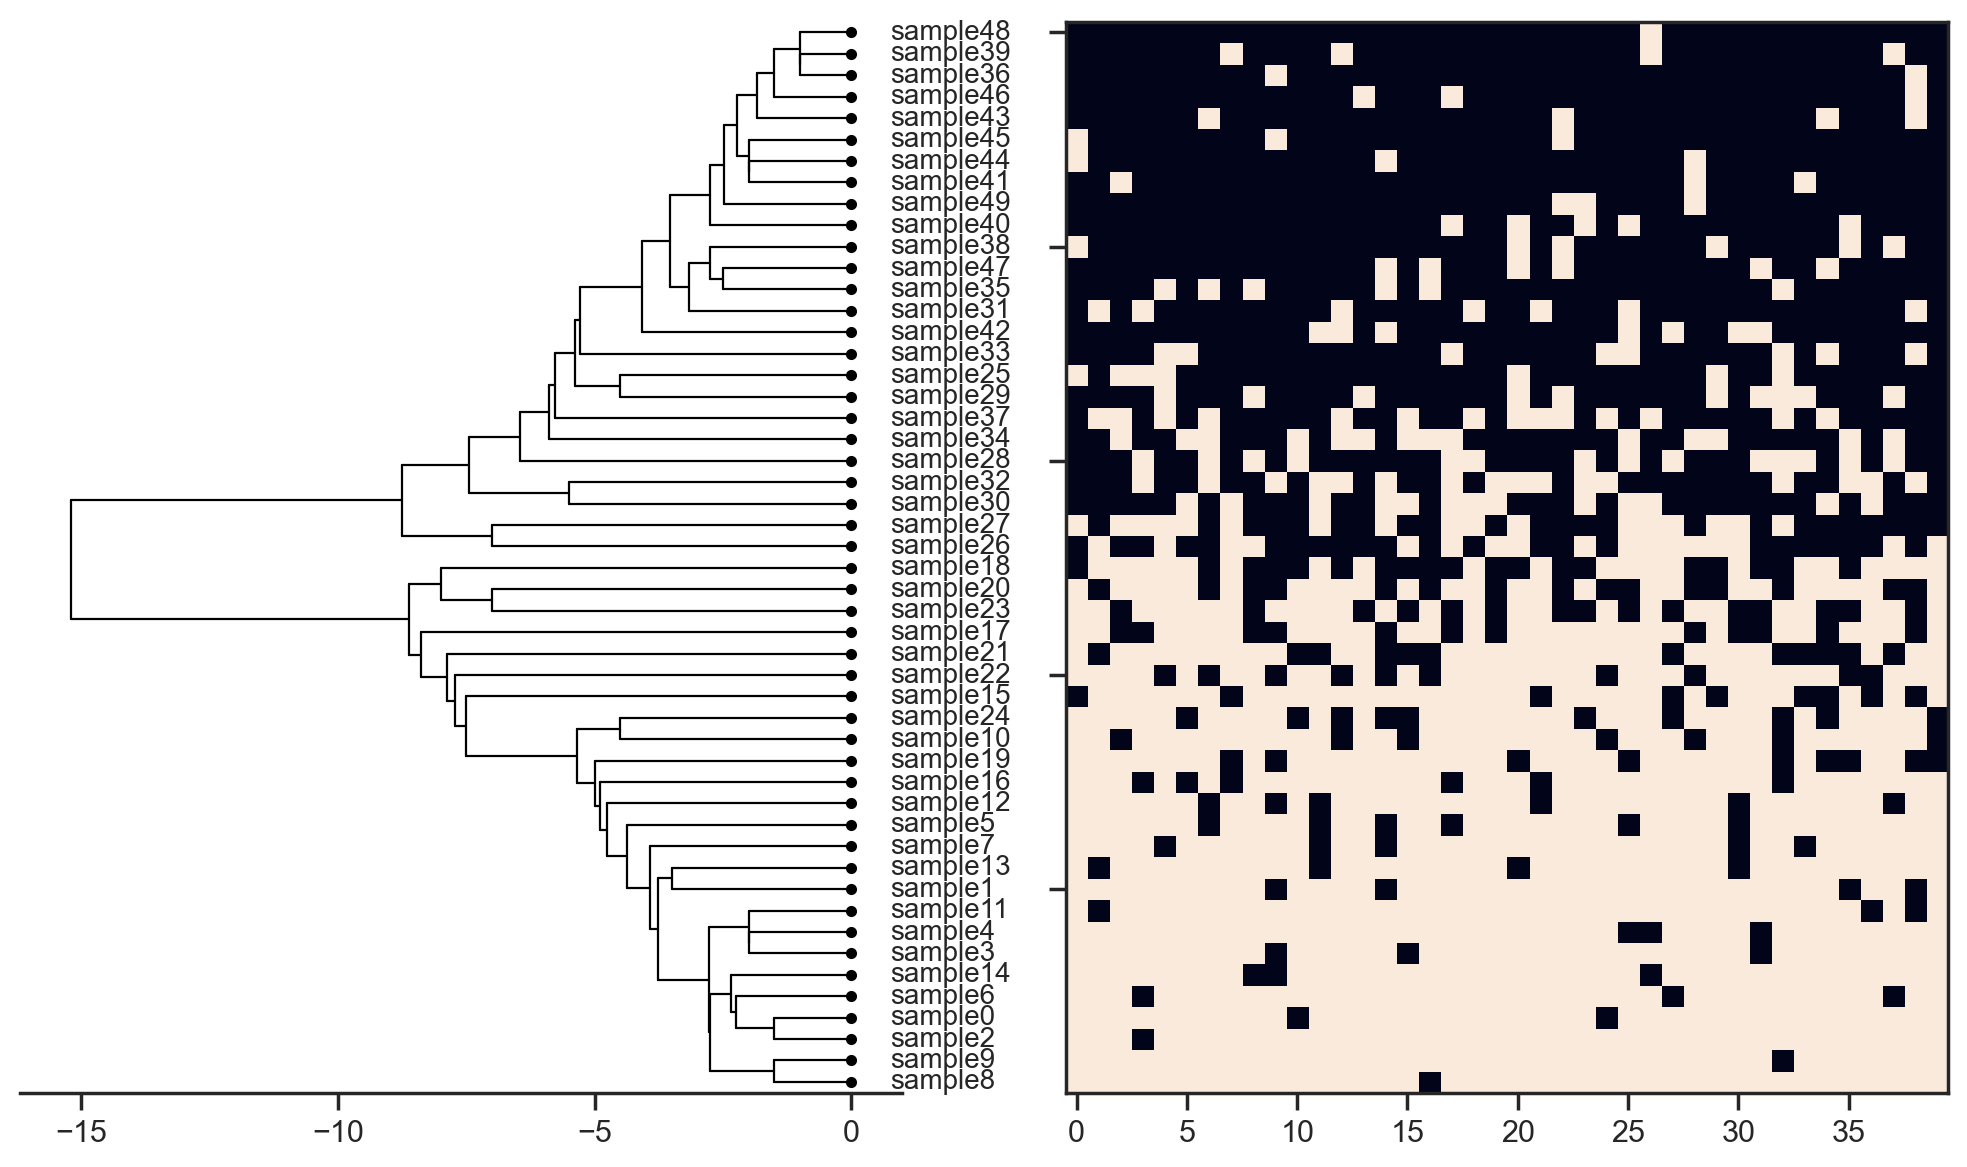

In [21]:
from ordering_haplotypes import tree_newick, order_tree, plot_tree
from ete3 import Tree
    
def proportion_same_ancestry(*args):
    a, b, case_sensitive = args
    "a and b are arrays or seris of posterior probabilities of minor parent ancestry"
    return np.absolute(a.round() - b.round()).sum()

newick_str = tree_newick(sample_name_list, seq_window_list, dist_fun=proportion_same_ancestry)
tree = Tree(newick_str)

def order_fun(c):
    leaf_names = [x.name for x in c.get_leaves()]
    idx = [sample_name_list.index(x) for x in leaf_names]
    return seq_window_list[idx].mean()

order_tree(tree, key=order_fun)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 6))

leaf_info = plot_tree(tree, ax1, fontsize=10)
names, x, y = zip(*leaf_info)
idx = [sample_name_list.index(x) for x in names]

print("Index of sorted haplotypes:", idx)

sorted_seq_window_list = np.array([seq_window_list[i] for i in idx])
ax2.imshow(sorted_seq_window_list, aspect='auto') ;
ax2.invert_yaxis()
plt.tight_layout()

(array([77107.,   443.,   495.,   358.,   461.,  1952.,   417.,   404.,
          427., 12540.]),
 array([     0.,  20000.,  40000.,  60000.,  80000., 100000., 120000.,
        140000., 160000., 180000., 200000.]),
 <BarContainer object of 10 artists>)

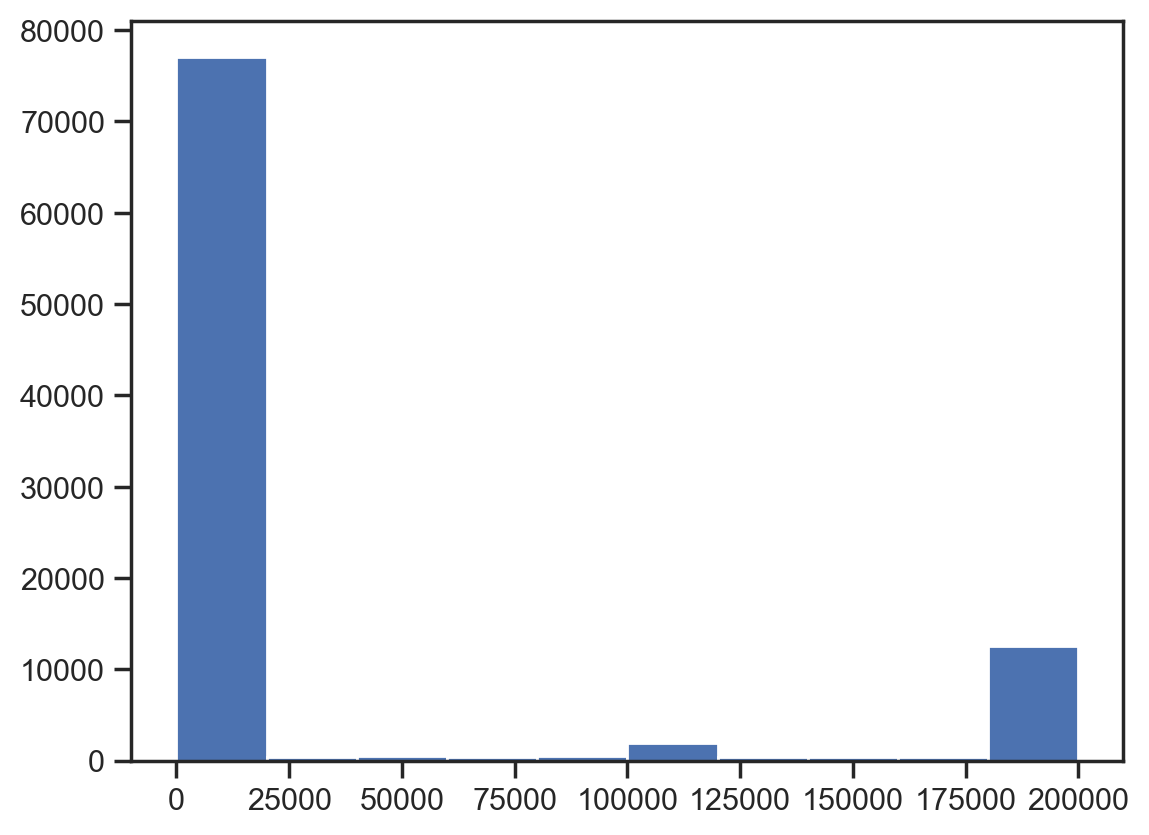

In [23]:
plt.hist(window_df.north)

In [26]:
window_df.head()

,windows,"Anubis, Tanzania","Hamadryas, Ethiopia","Cynocephalus, Central Tanzania","Papio, Senegal",chrom,individual,Origin,north,norm_north,start,is_north,is_south
0,2500194,200000.0,0.0,0.0,0.0,chrX,Sci_30877,"Aberdare, Kenya",0.0,-100000.0,2500194,0,0
1,2600194,200000.0,0.0,0.0,0.0,chrX,Sci_30877,"Aberdare, Kenya",0.0,-100000.0,2600194,0,0
2,2700194,200000.0,0.0,0.0,0.0,chrX,Sci_30877,"Aberdare, Kenya",0.0,-100000.0,2700194,0,0
3,2800194,200000.0,0.0,0.0,0.0,chrX,Sci_30877,"Aberdare, Kenya",0.0,-100000.0,2800194,0,0
4,2900194,200000.0,0.0,0.0,0.0,chrX,Sci_30877,"Aberdare, Kenya",0.0,-100000.0,2900194,0,0


In [33]:
window_df.start.unique()

array([  2500194,   2600194,   2700194, ..., 143400194, 143500194,
       143600194])

In [32]:
# df = pd.read_csv('chr20_test.txt')
df = window_df

df['haplo_ID'] = df.individual
df['pos'] = df.start
df['end_pos'] = df.start + 100000

df['chrom'] = 'chrX'
df['pop'] = df.haplo_ID
df['is_north'] = (df.north == 1).astype(int)
df['is_south'] = (df.north == -1).astype(int)
df = df.sort_values(['pop', 'chrom', 'start'])

haplo_ID_list = list(df.haplo_ID.unique())

north_south_segment_lists = []
for sample_name in haplo_ID_list:
    north_tuples = list(df.loc[(df.haplo_ID == sample_name) & (df.is_north == 1), ['pos', 'end_pos']].itertuples(index=False, name=None))
    south_tuples = list(df.loc[(df.haplo_ID == sample_name) & (df.is_north == 0), ['pos', 'end_pos']].itertuples(index=False, name=None))
    north_south_segment_lists.append((north_tuples, south_tuples))

def tot_overlap(arr1, arr2):
    """total overlap of two lists of intervals"""
    tot = 0
    i = j = 0
    n = len(arr1)
    m = len(arr2)
    while i < n and j < m:
        l = max(arr1[i][0], arr2[j][0])
        r = min(arr1[i][1], arr2[j][1])
        if l <= r: 
            tot += r - l
        if arr1[i][1] < arr2[j][1]:
            i += 1
        else:
            j += 1
    return tot

def proportion_same_ancestry(*args):
    """proportion of chromsome with same ancestry"""
    a, b, case_sensitive = args
    ovl = tot_overlap(a[0], b[0]) + tot_overlap(a[1], b[1])
    return 77000000 - ovl
    
newick_str = tree_newick(haplo_ID_list, north_south_segment_lists, dist_fun=proportion_same_ancestry)
tree = Tree(newick_str)

def order_fun(c):
    """order child clades so that leaves in left has more north ancestry"""
    leaf_names = [x.name for x in c.get_leaves()]
    idx = [haplo_ID_list.index(x) for x in leaf_names]
    return sum(e-s for i in idx for (s, e) in north_south_segment_lists[i][1]) - sum(e-s for i in idx for (s, e) in north_south_segment_lists[i][0])

order_tree(tree, key=order_fun)

fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=(5, 5))

leaf_info = plot_tree(tree, ax1, fontsize=2)
haplo_ID_sorting, x, y = zip(*leaf_info)

ValueError: Image size of -446151440x864 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 500x500 with 1 Axes>

/Users/kmt/miniconda3/envs/baboons/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/kmt/miniconda3/envs/baboons/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/kmt/miniconda3/envs/baboons/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


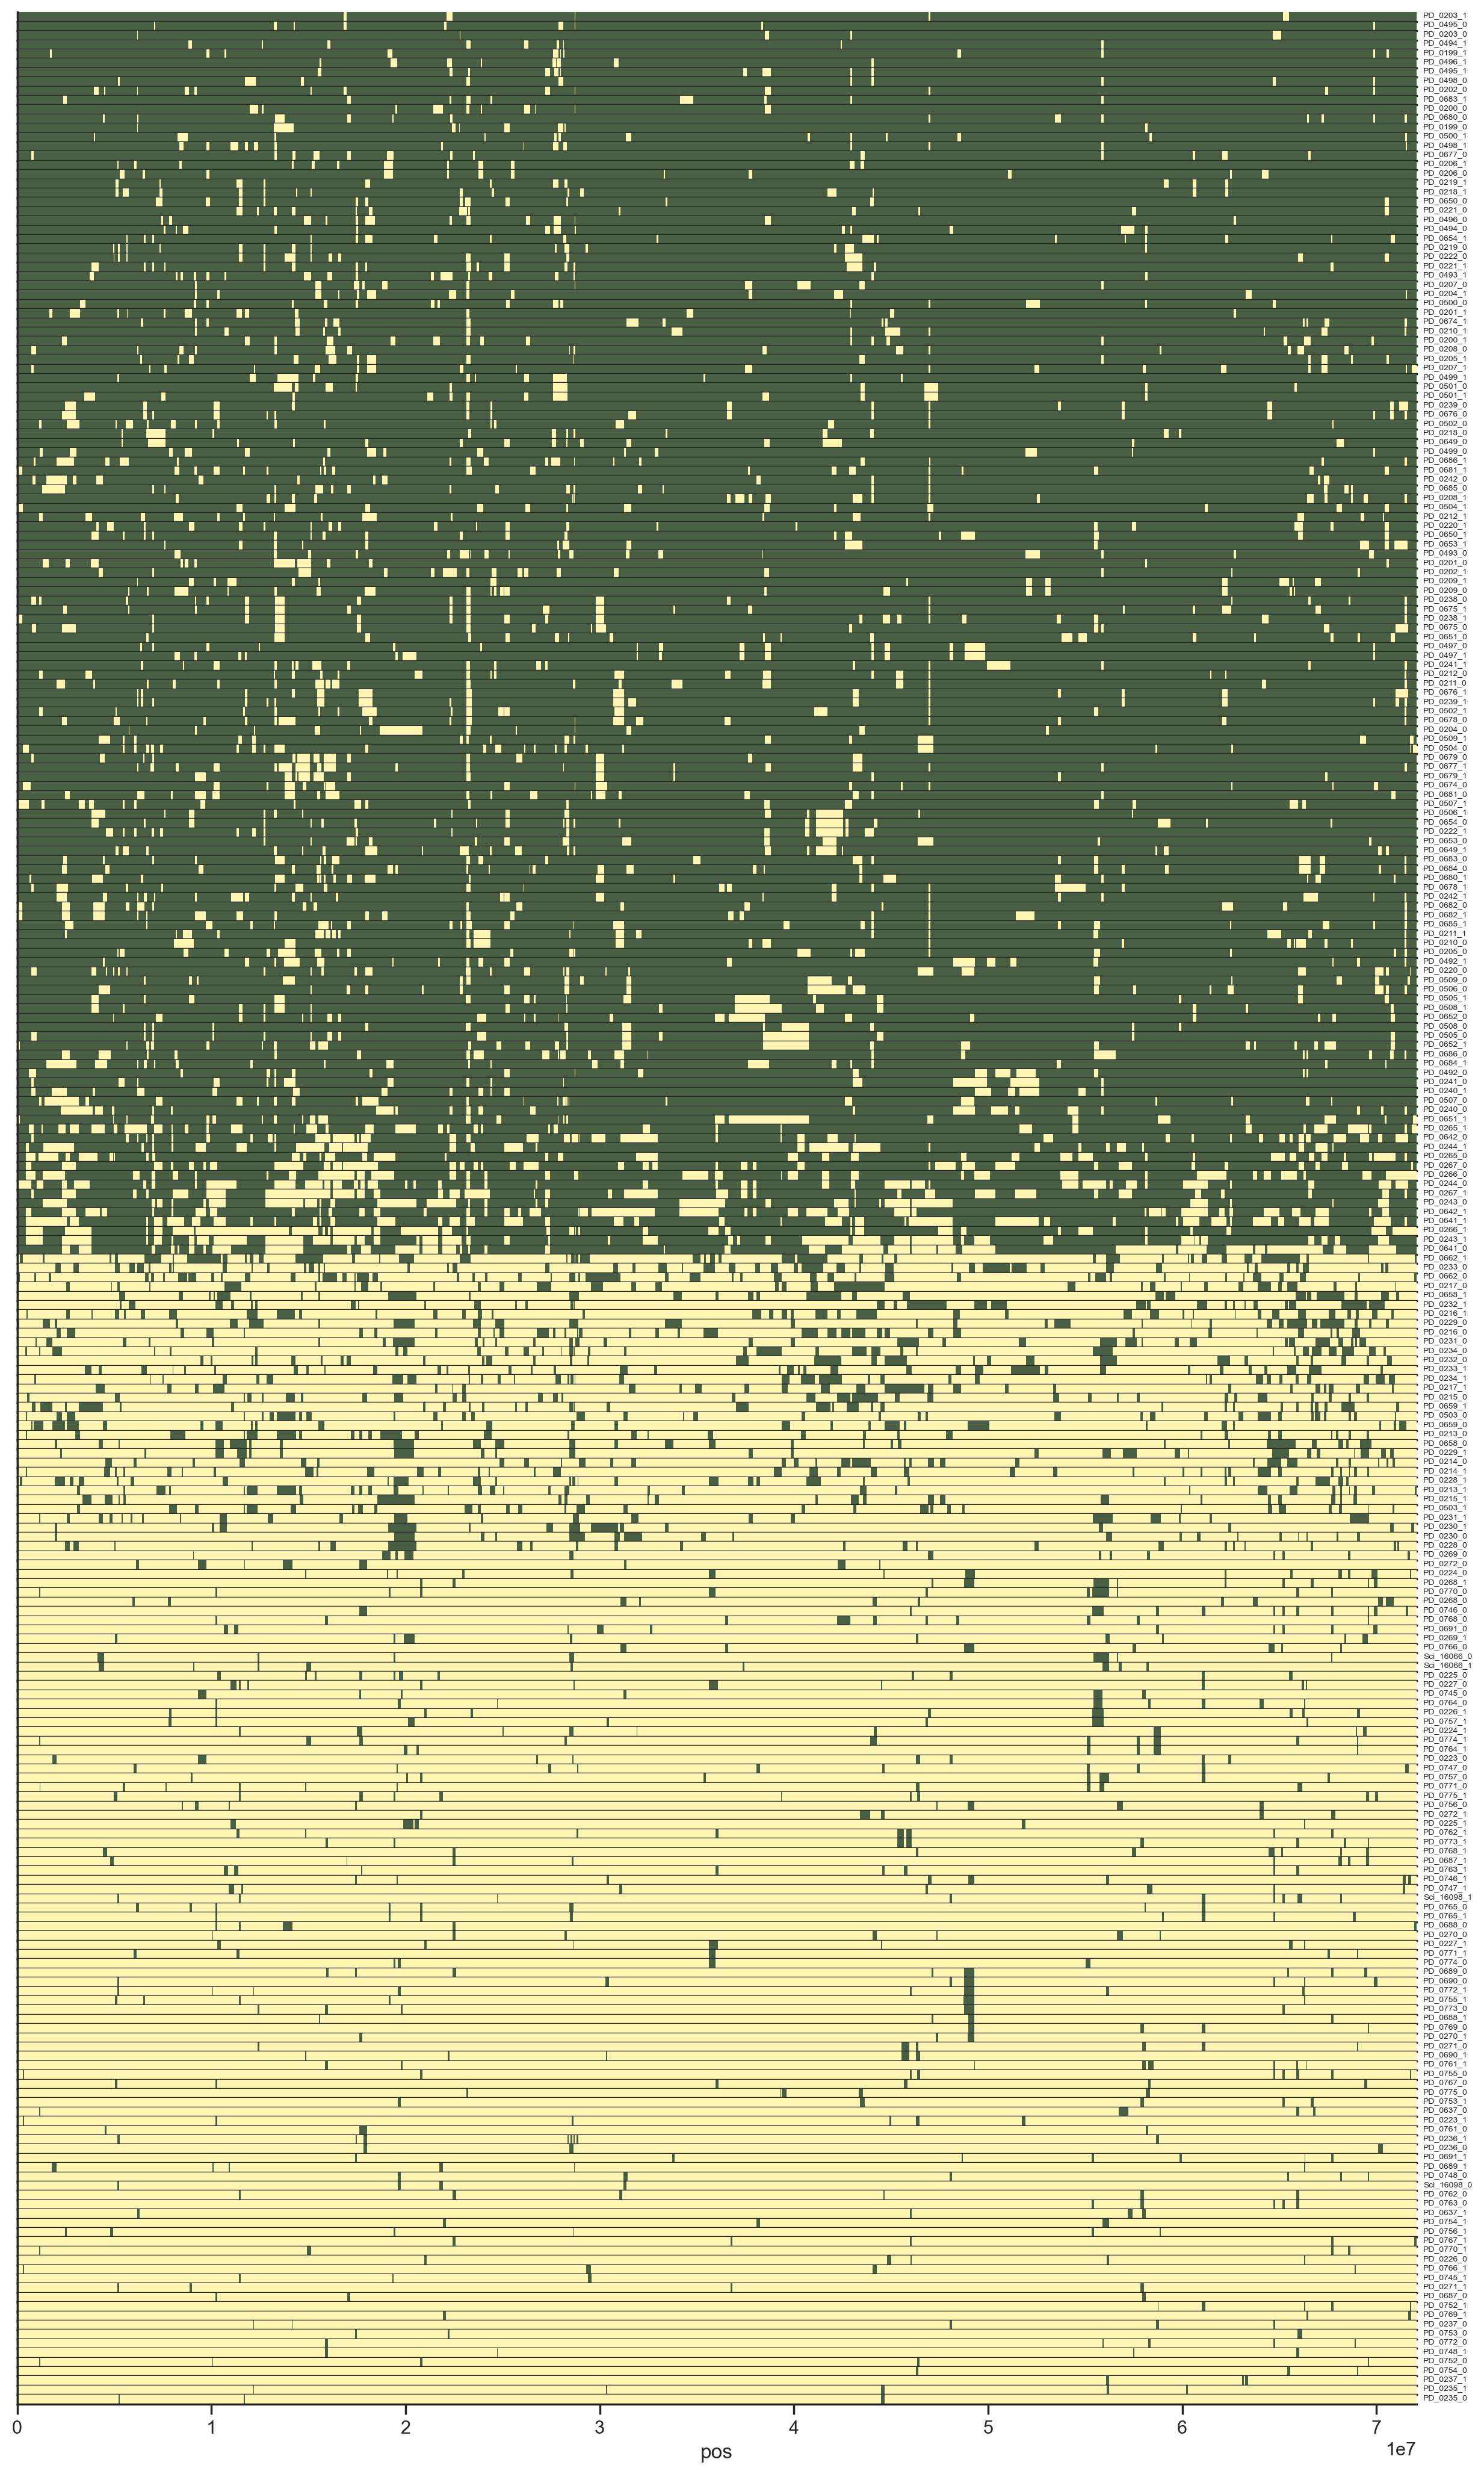

In [85]:
def stairs(df, start='pos', end='end_pos', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

g = sns.FacetGrid(stairs(df), col='chrom', row='haplo_ID', sharex=True, sharey=True, height=0.1, aspect=150,
                    row_order=haplo_ID_sorting, margin_titles=True, gridspec_kws={'hspace':0.0})
g.map(plt.fill_between, 
    'pos', 
    'is_north', 
    y2=0,
    color='#495F43',
    linewidth=0,
    capstyle='butt')
g.map(plt.fill_between, 
    'pos', 
    'is_south', 
    y2=0,
    color='#FFF6B4',
    linewidth=0,
    capstyle='butt')
g.set_titles(col_template="", row_template="")
g.set(yticklabels=[])  
g.set(ylabel=None)
g.tick_params(left=False)  # remove the ticks 
for label, ax in zip(hap_sorting, g.axes.flat):
    ax.set_xlim(plot_df.pos.min(), plot_df.pos.max())
    ax.set_ylim(0, 1)    
    ax.annotate(label, xy=(1.005 , 0.5), xycoords='axes fraction', ha='left', size=5)
    ax.set_xticks(np.arange(0, max(df.pos)+1, 10000000))